In [11]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [12]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')

In [17]:
m2005 =pd.read_pickle('./observations/IOS_ctd_moor_2005.p')
m2010 =pd.read_pickle('./observations/IOS_ctd_moor_2010.p')
m2015 =pd.read_pickle('./observations/IOS_ctd_moor_2015.p')
m2020 =pd.read_pickle('./observations/IOS_ctd_moor_2020.p')
ios_moor = pd.concat([m2005,m2010,m2015,m2020])
ios_moor.head()

,longitude (degrees_east),latitude (degrees_north),sea_water_pressure (dbar),depth (m),sea_water_temperature (degC),sea_water_practical_salinity (PSS-78),DOXYZZ01 (mL/L),time
0,-123.424450,49.027150,13.177000,13.064797,9.5504,28.440600,NaN,2008-11-19 00:00:00+00:00
145,-126.203865,48.529617,40.143800,39.801180,NaN,32.426140,NaN,2009-05-24 00:00:00+00:00
146,-126.203865,48.529617,39.714828,39.375910,NaN,32.388807,NaN,2009-05-25 00:00:00+00:00
147,-126.203865,48.529617,39.632032,39.293829,NaN,32.367177,NaN,2009-05-26 00:00:00+00:00
148,-126.203865,48.529617,39.674800,39.336227,NaN,32.375100,NaN,2009-05-27 00:00:00+00:00


In [19]:
# very quick qa/qc
# remove all unreasonable values
# ios_prof.loc[ios_prof['sea_water_temperature (degC)'] > 40, 'sea_water_temperature (degC)'] = pd.NA
# ios_prof.loc[ios_prof['sea_water_temperature (degC)'] <-3, 'sea_water_temperature (degC)'] = pd.NA

# ios_prof.loc[ios_prof['sea_water_practical_salinity (PSS-78)'] > 50, 'sea_water_practical_salinity (PSS-78)'] = pd.NA
# ios_prof.loc[ios_prof['sea_water_practical_salinity (PSS-78)'] < 0, 'sea_water_practical_salinity (PSS-78)'] = pd.NA

ios_moor.loc[ios_moor['sea_water_temperature (degC)'] > 40, 'sea_water_temperature (degC)'] = pd.NA
ios_moor.loc[ios_moor['sea_water_temperature (degC)'] <-3, 'sea_water_temperature (degC)'] = pd.NA

ios_moor.loc[ios_moor['sea_water_practical_salinity (PSS-78)'] > 50, 'sea_water_practical_salinity (PSS-78)'] = pd.NA
ios_moor.loc[ios_moor['sea_water_practical_salinity (PSS-78)'] < 0, 'sea_water_practical_salinity (PSS-78)'] = pd.NA

/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


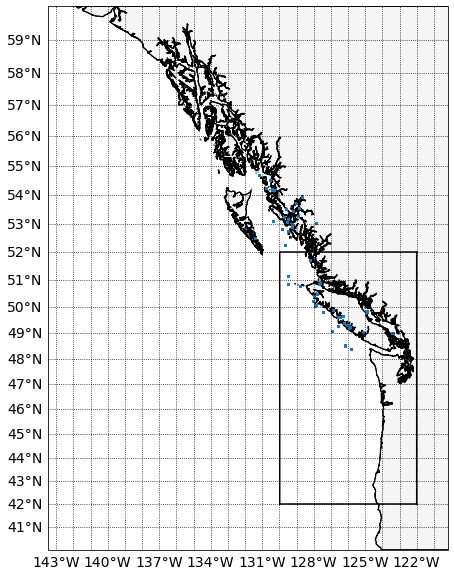

In [20]:
# Increase font size
plt.rcParams['font.size'] = 14

# Make plot area
xlim, ylim = [-143.5, -120.2], [40, 60]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Draw box
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

# add points
# ax.scatter(ios_prof['longitude (degrees_east)'], ios_prof['latitude (degrees_north)'], s=3, marker='*', label='profiles',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ios_moor['longitude (degrees_east)'], ios_moor['latitude (degrees_north)'], s=3, marker='*', label='mooring',transform=crs.PlateCarree(),zorder=7)


In [15]:
# ooi_chl = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_chlorophyll.p')
# ooi_co2 = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_co2.p')
# ooi_oxy = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_oxygen.p')
ooi_nit = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/OOI_nitrate.p')

In [9]:
print(len(ooi_chl))
print(len(ooi_co2))
print(len(ooi_oxy))
print(len(ooi_nit))


953302
766819
1631564
496933


/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/rbeutel/anaconda3/envs/Ariane/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


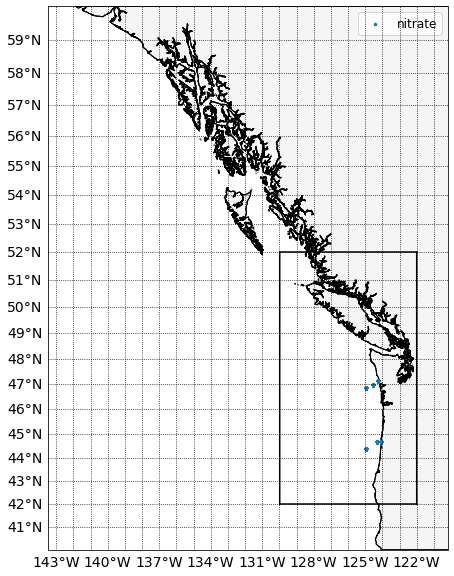

In [21]:
# Increase font size
plt.rcParams['font.size'] = 14

# Make plot area
xlim, ylim = [-143.5, -120.2], [40, 60]
fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
ax.set_extent(xlim + ylim)

# Draw coastline
ax.add_feature(feature.GSHHSFeature('full', facecolor='whitesmoke', zorder=2))
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', zorder=4))

# Add gridlines
xlocs, ylocs = [np.arange(np.floor(l[0]), np.ceil(l[1])+1) for l in [xlim, ylim]]
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True, xlocs=xlocs, ylocs=ylocs, zorder=8)
gl.xformatter, gl.yformatter = LONGITUDE_FORMATTER, LATITUDE_FORMATTER
gl.xlabels_top, gl.ylabels_right = False, False

# Draw box
ax.plot(grid.lon_rho[:,0], grid.lat_rho[:,0], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[:,-1], grid.lat_rho[:,-1], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[-1,:], grid.lat_rho[-1,:], 'k-', zorder=6, transform=crs.PlateCarree())
ax.plot(grid.lon_rho[0,:], grid.lat_rho[0,:], 'k-', zorder=6, transform=crs.PlateCarree())

# add points  
# ax.scatter(ooi_oxy['longitude (degrees_east)'], ooi_oxy['latitude (degrees_north)'], s=10, marker='*', label='oxygen',transform=crs.PlateCarree(),zorder=7)
# ax.scatter(ooi_chl['longitude (degrees_east)'], ooi_chl['latitude (degrees_north)'], s=10, marker='*', label='chlorophyll',transform=crs.PlateCarree(),zorder=7)
ax.scatter(ooi_nit['longitude (degrees_east)'], ooi_nit['latitude (degrees_north)'], s=10, marker='*', label='nitrate',transform=crs.PlateCarree(),zorder=7)
# ax.scatter(ooi_co2['longitude (degrees_east)'], ooi_co2['latitude (degrees_north)'], s=10, marker='*', label='co2',transform=crs.PlateCarree(),zorder=7)

ax.legend(fontsize=12)

In [4]:
onc = pd.read_pickle('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/tracers/observations/ONC.p')

In [5]:
onc

,salinity (1e-3),temperature (K),pressure (dbar),longitude (degrees_east),latitude (degrees_north),depth (m),time,datetime
0,33.976662,278.919657,384.359069,-125.875583,48.333200,415.0,2017-06-15 00:00:00+00:00,0
1,33.972299,278.968565,384.451806,-125.875583,48.333200,415.0,2017-06-16 00:00:00+00:00,1
2,33.973896,278.951451,384.459194,-125.875583,48.333200,415.0,2017-06-17 00:00:00+00:00,2
3,33.969292,279.005725,384.460333,-125.875583,48.333200,415.0,2017-06-18 00:00:00+00:00,3
4,33.976367,278.925754,384.443167,-125.875583,48.333200,415.0,2017-06-19 00:00:00+00:00,4
...,...,...,...,...,...,...,...,...
1744,33.674261,280.599844,228.736927,-124.750093,48.508338,227.0,2015-09-08 00:00:00+00:00,351
1745,33.684544,280.590158,228.733510,-124.750093,48.508338,227.0,2015-09-09 00:00:00+00:00,352
1746,33.710015,280.546932,228.729875,-124.750093,48.508338,227.0,2015-09-10 00:00:00+00:00,353
1747,33.720744,280.561509,228.726094,-124.750093,48.508338,227.0,2015-09-11 00:00:00+00:00,354
